***
Minwoo Kim (mkim180@uw.edu) (Last update on: May 1,2020)

note: Kim et al. Deep-learning Image Reconstruction for Real-time Photoacoustic System, IEEE TMI, 2020
***
## **Testing using a trained structure**

In [1]:
### Import libraries/modules/packages 
from __future__ import print_function # compatibility in Python versions
from skimage.io import imsave, imread # image save and read 
from skimage.transform import resize # image resize
from matplotlib import pyplot as plt # image plot
import numpy as np # package for computing
import numpy.fft as fft # fft
from numpy.testing import assert_allclose
# Deeplearning perpose 
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, Lambda
from keras.layers import BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.engine.topology import Layer
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
# Set Path
import os
currentPath=os.getcwd()
print(currentPath)

C:\Users\bugee\OneDrive\Documents\Jupyer\codeUpload


In [3]:
# Load test rf data
testInp = np.load('data/vasc/rawData.npy')
testInp = testInp[..., np.newaxis]

nFrames,nRows,nCols,nChanIn = testInp.shape

# Load ground-truth images
testOut = np.load('data/vasc/groundT.npy')
testOut = testOut[..., np.newaxis]
nFrames2,nRows2,nCols2,nChanOut = testOut.shape

# Normalization 
stdv = 43;
testOut = testOut/stdv


In [5]:
# Load transformation matrix (sparse matrix)
alignMat = np.load('table/LUTMat.npy')

nChs = 128
nnz,npp = alignMat.shape
alignInx=[]
alignVal=[]
for i in range(0,nnz):
    v1 = (alignMat[i,0]).astype(int)-1
    v2 = (alignMat[i,1]).astype(int)-1
    alignInx.append([v1,v2])
    alignVal.append(alignMat[i,2])
alignShape = [nRows2*nCols2*nChs,nRows*nCols]

In [6]:
### Define functions for deep learning

# TF dimension ordering in this code
K.set_image_data_format('channels_last') 

def abs_func(x):
    return K.abs(x)

class DeepLearning:
    def __init__(self):
        self.img_rows = 512
        self.img_cols = 128
        self.img_channels = 2
        self.data_rows = 2048
        self.data_cols = 128
        self.alignChs = 64
        self.smooth = 1
        self.irfMat = 0
        self.projMat = 0
        
    def setImgSize(self, img_rows, img_cols, img_channels):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.img_channels = img_channels
        
    def setChSize(self,chs):
        self.alignChs = chs
        
    def setDataSize(self, data_rows, data_cols):
        self.data_rows = data_rows
        self.data_cols = data_cols
                
    def setAlignSparse(self, ind, val, shape):
        self.alignMat = tf.cast(tf.SparseTensor(indices=ind, values=val, dense_shape=shape),tf.float32)
    
  
    def get_unet(self,Nf):
        def my_lambda_func(z):
            
            x = tf.squeeze(z)
            x = tf.transpose(x,perm=[0,2,1])
            x2 = tf.reshape(tensor=x, shape=(-1, self.img_rows*self.img_cols))
            p = tf.transpose(tf.sparse.sparse_dense_matmul(self.alignMat,x2,adjoint_a=False, adjoint_b=True))
            pp = tf.reshape(tensor=p, shape=(-1, self.alignChs,self.data_cols,self.data_rows))
            pp = tf.transpose(pp,perm=[0,3,2,1])
            out = pp
            return out
        
        inputs = Input((self.img_rows, self.img_cols, self.img_channels))
        align1  =  Lambda(lambda z:my_lambda_func(z))(inputs)
        conv1 = Conv2D(Nf, (3, 3), activation='relu', padding='same')(align1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Conv2D(Nf, (3, 3), activation='relu', padding='same')(conv1)
        conv1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        #pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)
        #pool1 = Dropout(0.25)(pool1)

        conv2 = Conv2D(Nf*2, (3, 3), activation='relu', padding='same')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Conv2D(Nf*2, (3, 3), activation='relu', padding='same')(conv2)
        conv2 = BatchNormalization()(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        #pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)
        #pool2 = Dropout(0.25)(pool2)

        conv3 = Conv2D(Nf*4, (3, 3), activation='relu', padding='same')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Conv2D(Nf*4, (3, 3), activation='relu', padding='same')(conv3)
        conv3 = BatchNormalization()(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        #pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)
        #pool3 = Dropout(0.25)(pool3)

        conv4 = Conv2D(Nf*8, (3, 3), activation='relu', padding='same')(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Conv2D(Nf*8, (3, 3), activation='relu', padding='same')(conv4)
        conv4 = BatchNormalization()(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
        #pool4 = AveragePooling2D(pool_size=(2, 2))(conv4)
        #pool4 = Dropout(0.25)(pool4)

        conv5 = Conv2D(Nf*16, (3, 3), activation='relu', padding='same')(pool4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Conv2D(Nf*16, (3, 3), activation='relu', padding='same')(conv5)
        conv5 = BatchNormalization()(conv5)

        up6 = concatenate([Conv2DTranspose(Nf*8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
        conv6 = Conv2D(Nf*8, (3, 3), activation='relu', padding='same')(up6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Conv2D(Nf*8, (3, 3), activation='relu', padding='same')(conv6)
        conv6 = BatchNormalization()(conv6)

        up7 = concatenate([Conv2DTranspose(Nf*4, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
        conv7 = Conv2D(Nf*4, (3, 3), activation='relu', padding='same')(up7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Conv2D(Nf*4, (3, 3), activation='relu', padding='same')(conv7)
        conv7 = BatchNormalization()(conv7)

        up8 = concatenate([Conv2DTranspose(Nf*2, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
        conv8 = Conv2D(Nf*2, (3, 3), activation='relu', padding='same')(up8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Conv2D(Nf*2, (3, 3), activation='relu', padding='same')(conv8)
        conv8 = BatchNormalization()(conv8)

        up9 = concatenate([Conv2DTranspose(Nf, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
        conv9 = Conv2D(Nf, (3, 3), activation='relu', padding='same')(up9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Conv2D(Nf, (3, 3), activation='relu', padding='same')(conv9)
        conv9 = BatchNormalization()(conv9)

        conv10 = Conv2D(1, (1, 1), activation='linear')(conv9)
        
        model = Model(inputs=[inputs], outputs=[conv10])
        model.compile(optimizer='sgd', loss='mean_squared_error',metrics=['accuracy'])

        return model
     

In [7]:
# In the paper, "numFilters" is equal to 64. 
# Here, it is 128 for just testing
numFilters = 128
DL = DeepLearning()
DL.setImgSize(nRows, nCols, nChanIn)
DL.setDataSize(nRows2, nCols2)
DL.setChSize(nChs)
DL.setAlignSparse(alignInx,alignVal,alignShape)
model = DL.get_unet(numFilters)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 128, 128 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 128, 128 147584      lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 128, 128 512         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
# Load trained weights
model.load_weights('weights_Model.h5')
# Recon
testInpImg = testInp
testOutpImg = testOut
testPredImg = model.predict(testInpImg, verbose=1)

200/200 [==============================] - 20s 99ms/step


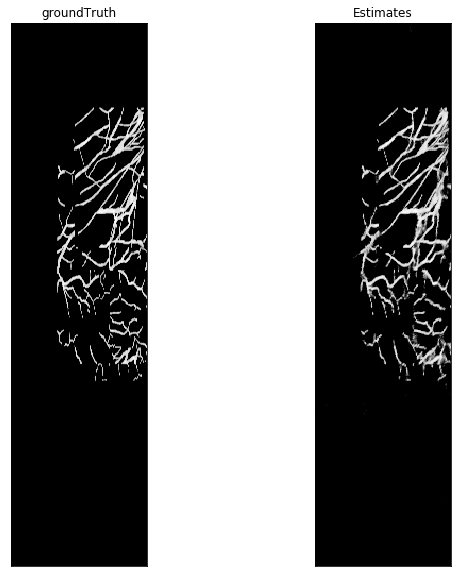

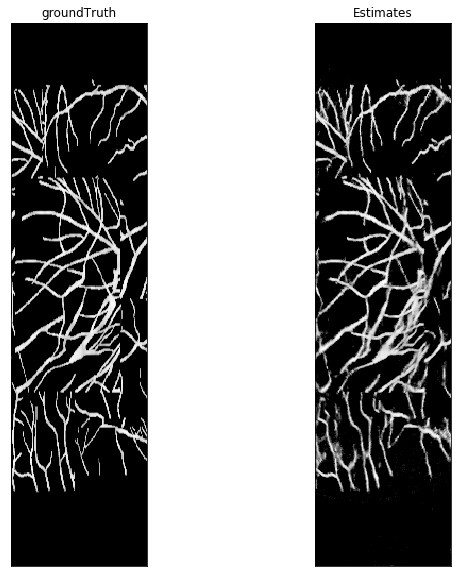

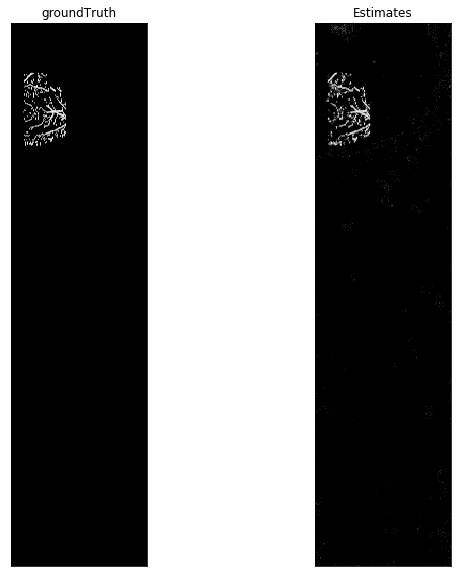

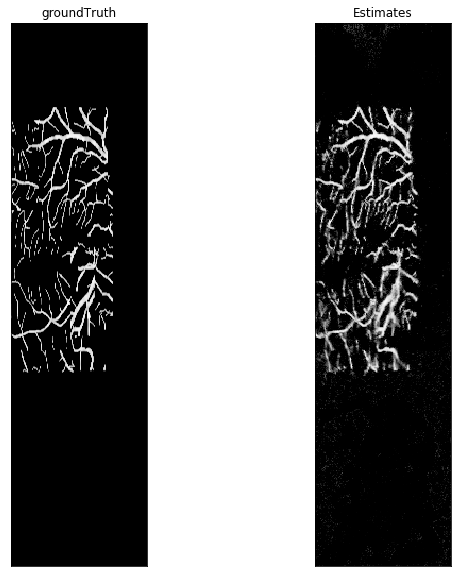

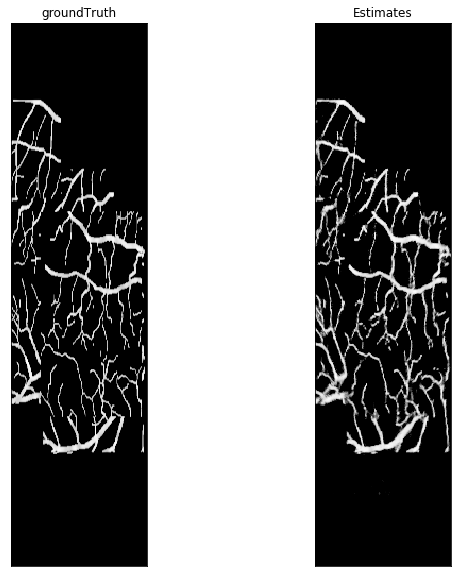

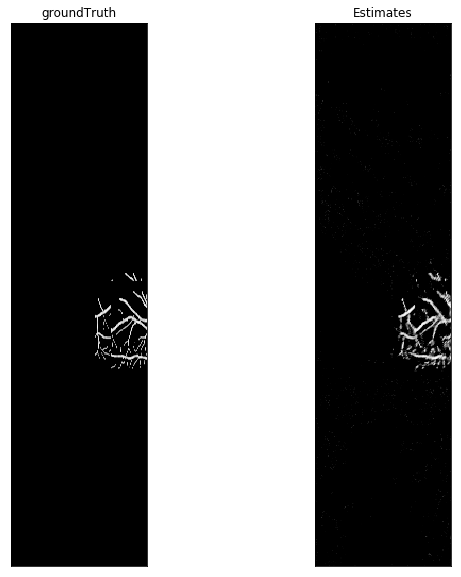

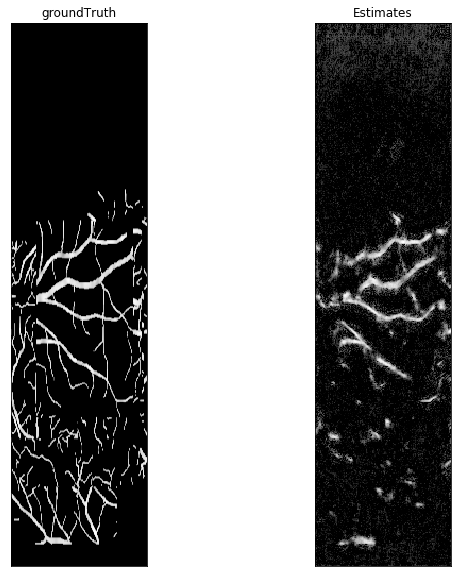

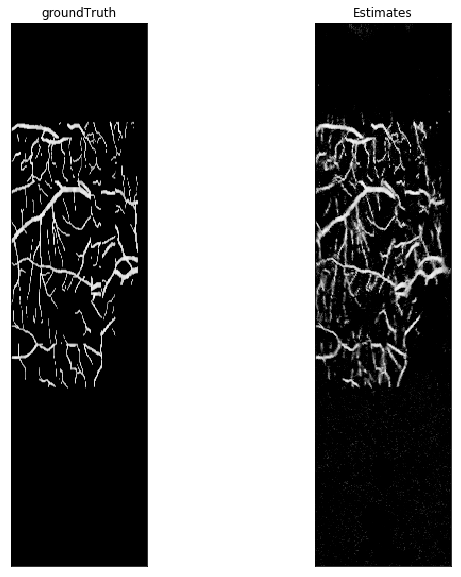

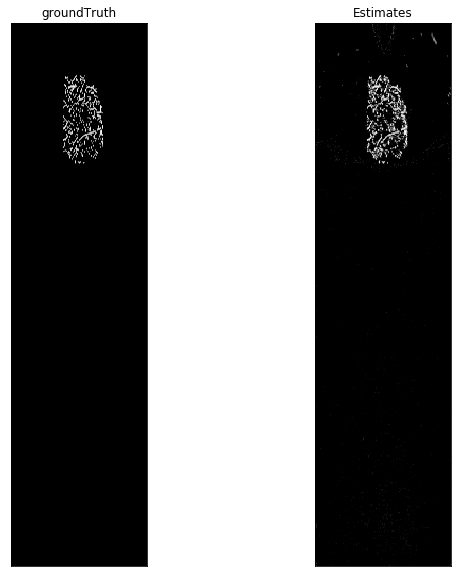

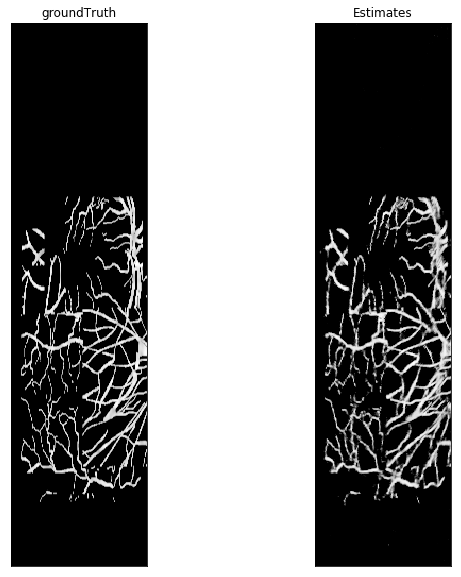

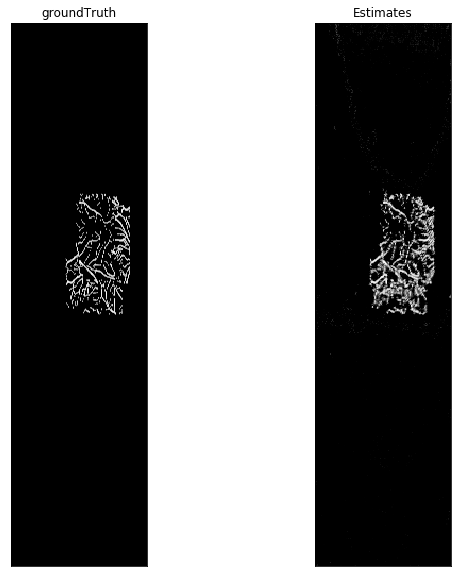

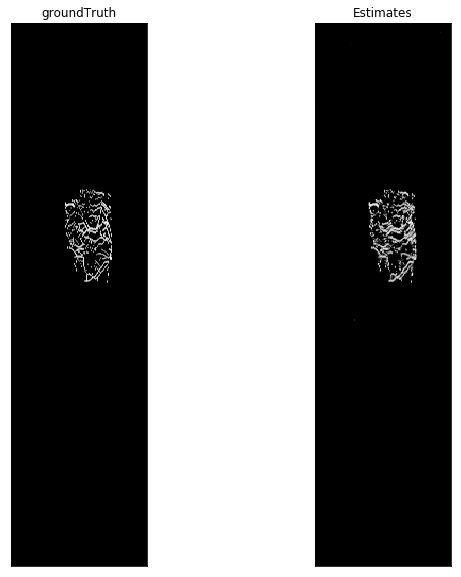

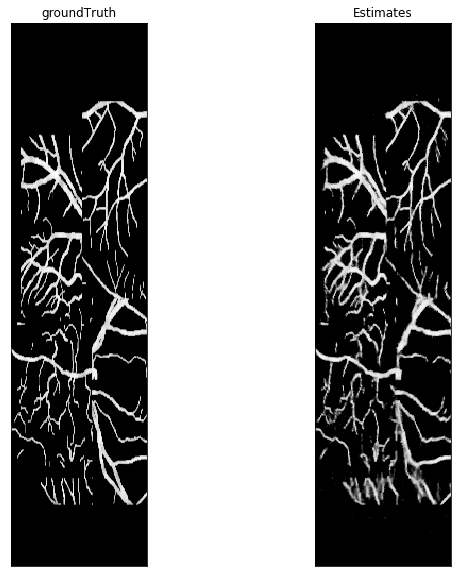

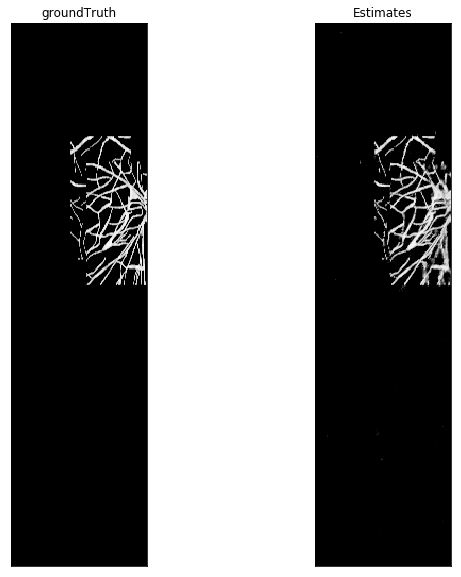

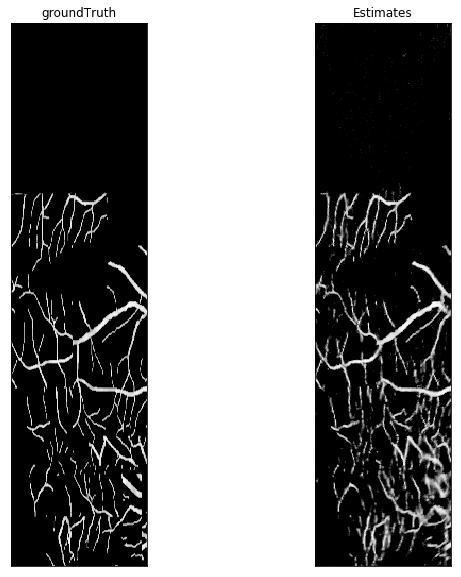

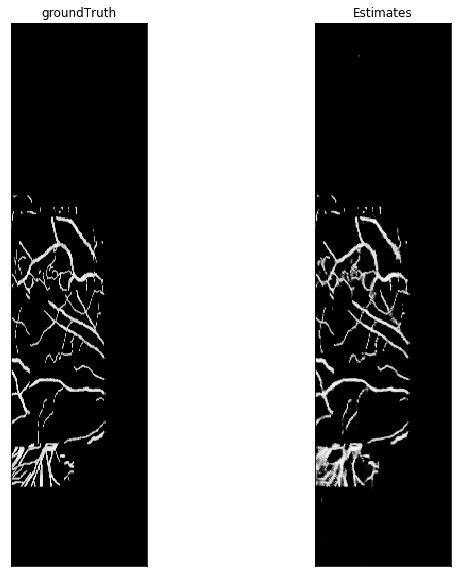

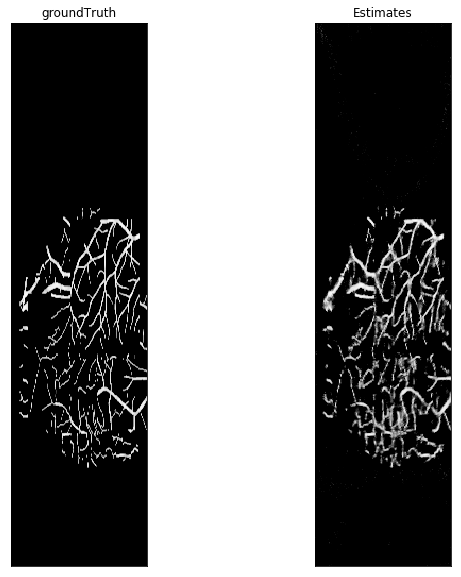

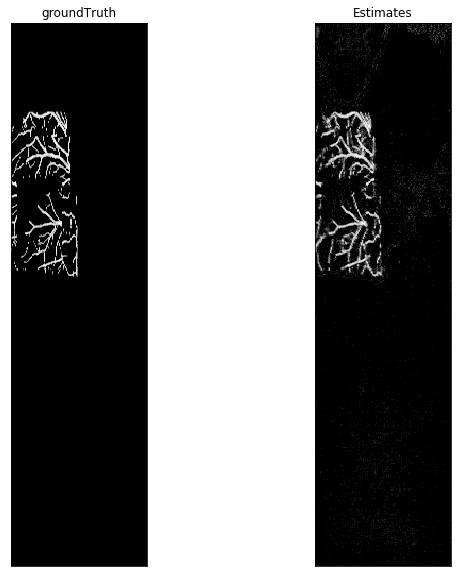

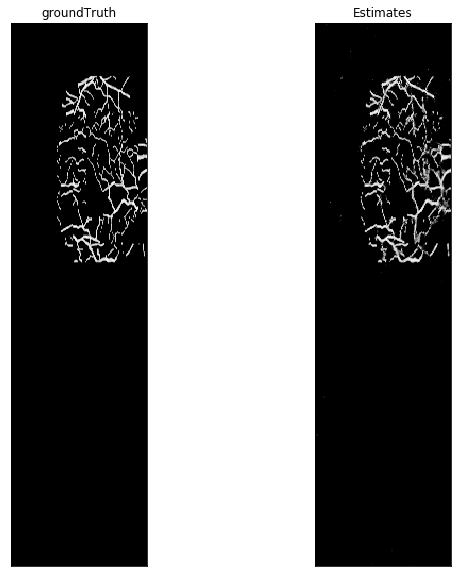

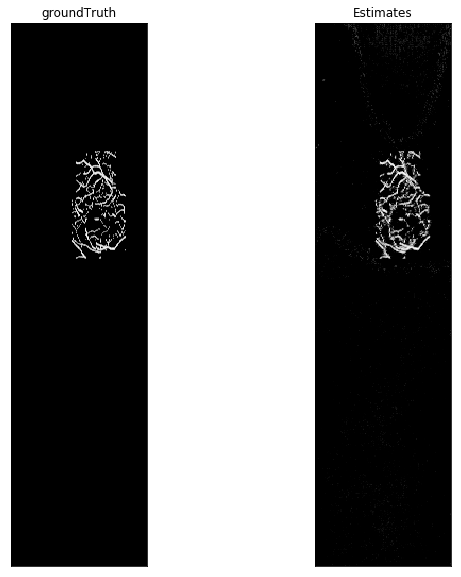

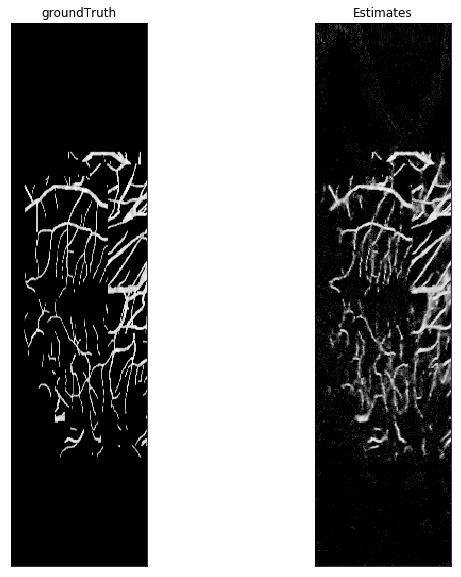

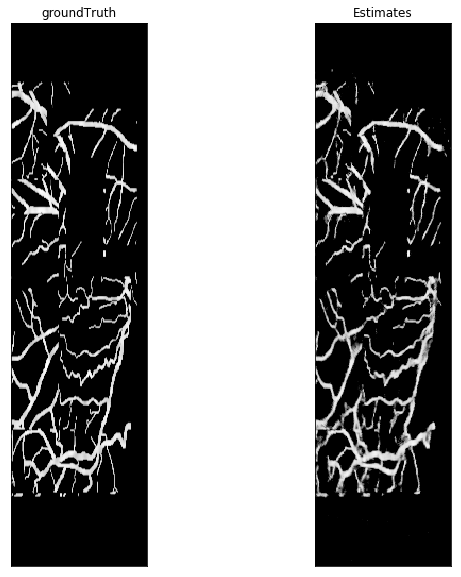

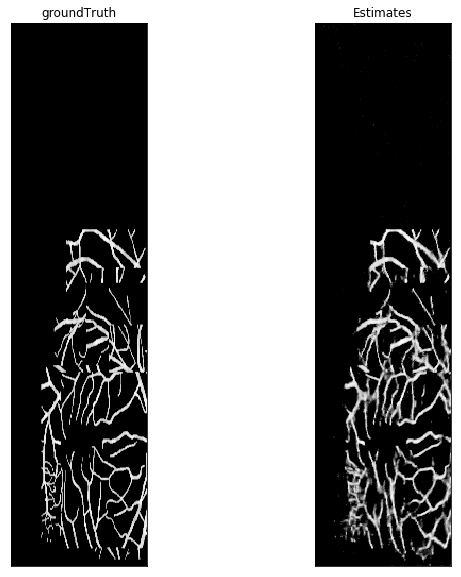

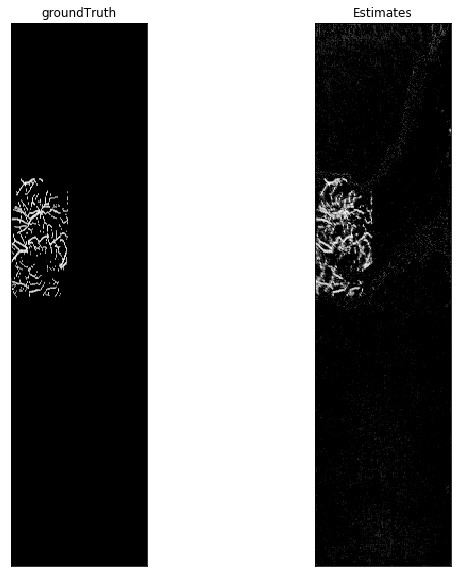

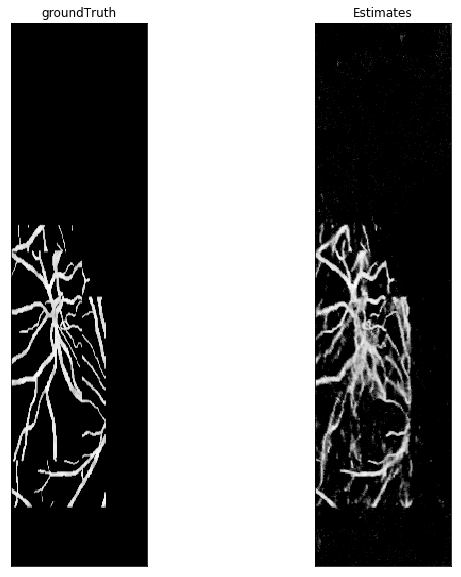

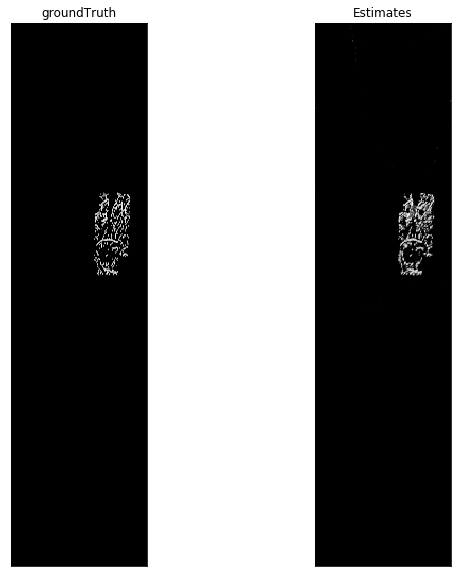

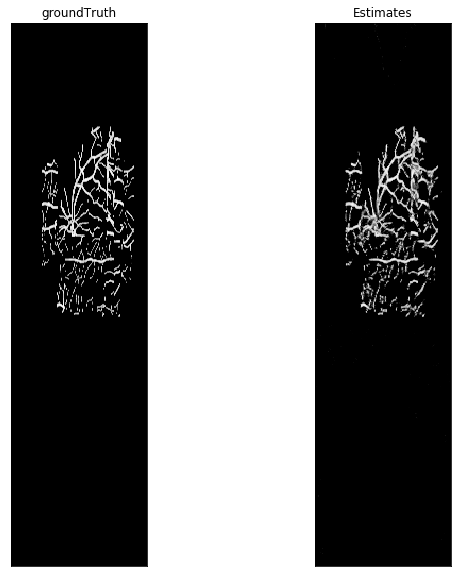

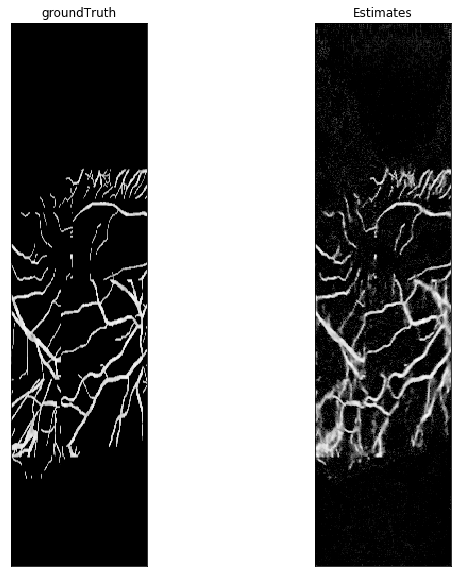

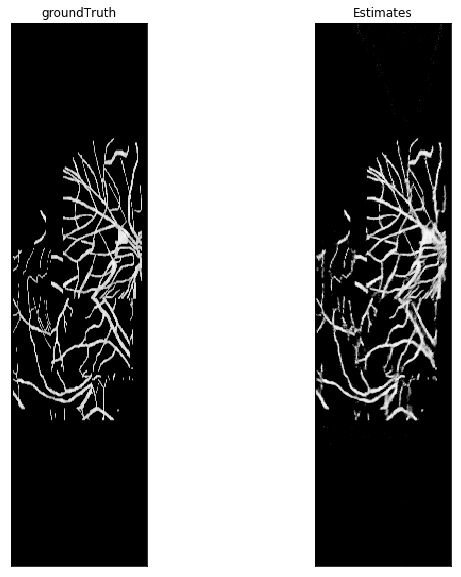

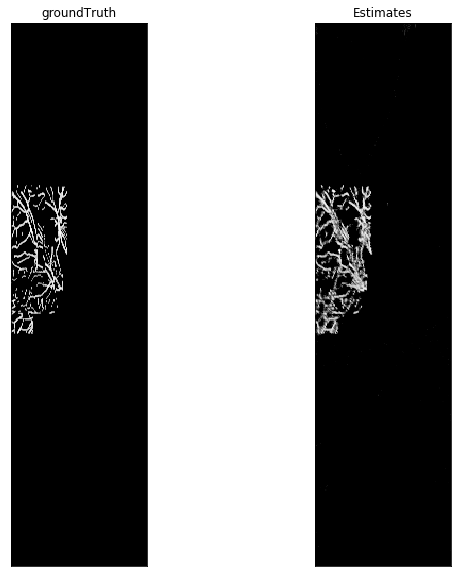

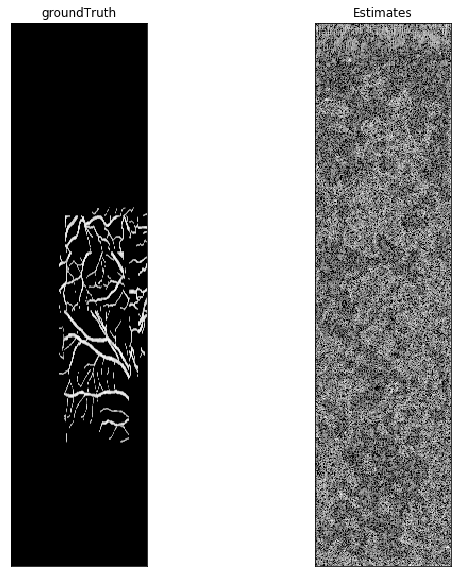

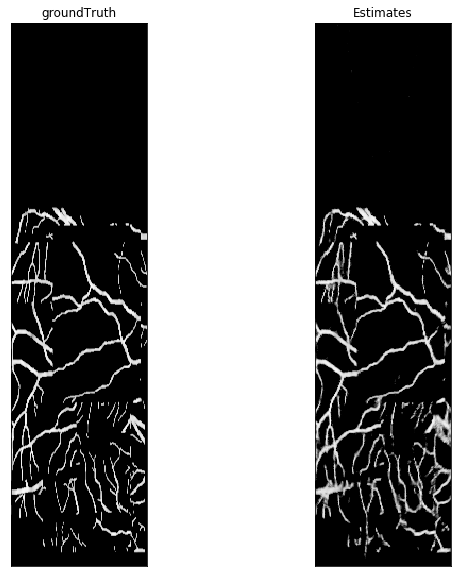

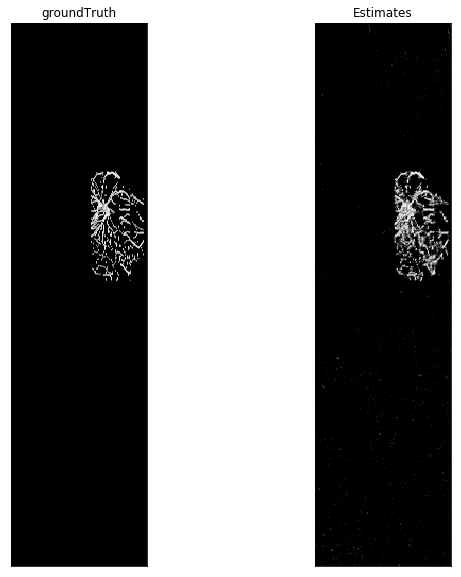

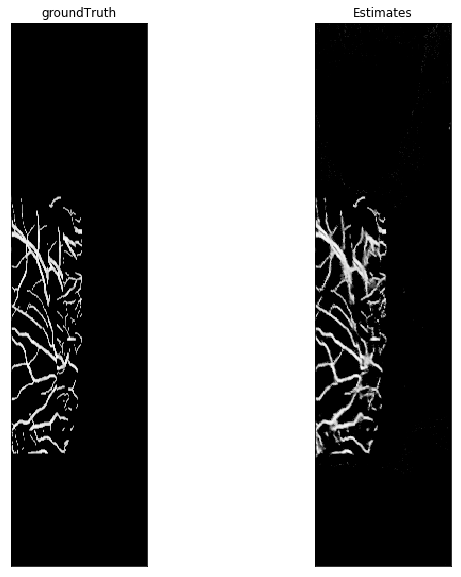

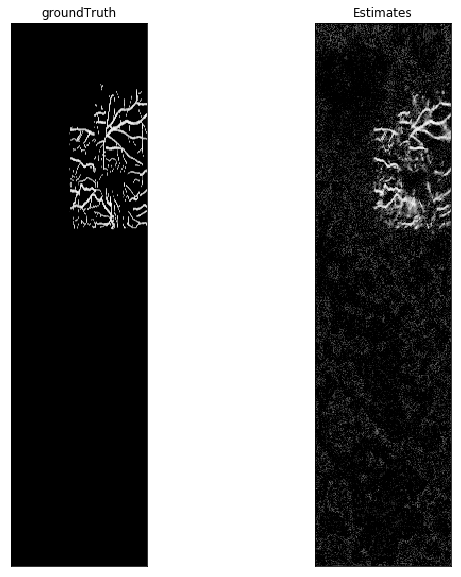

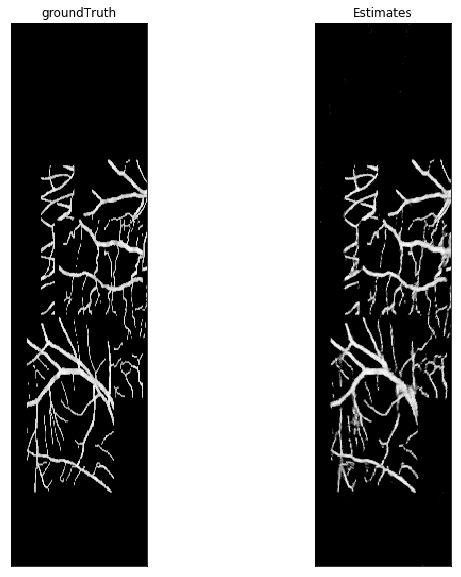

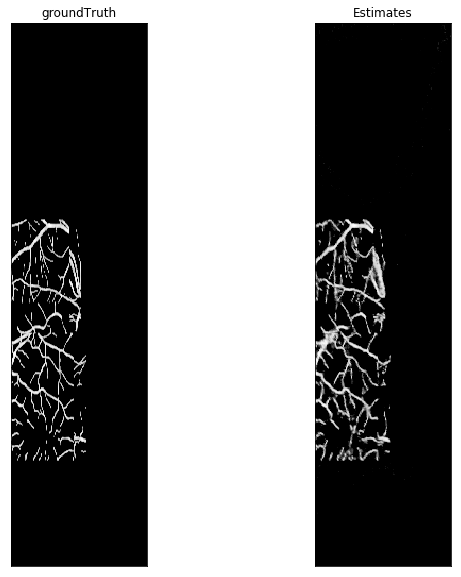

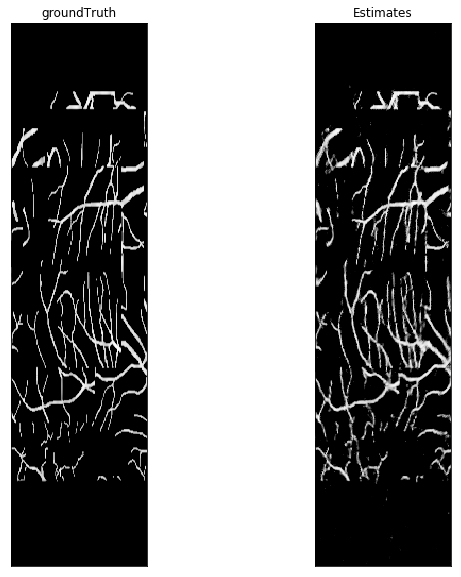

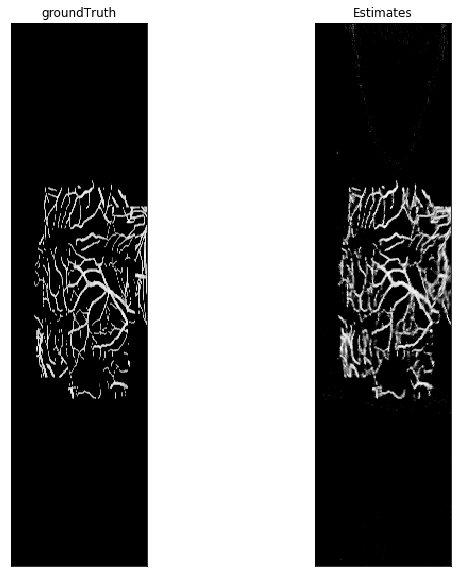

In [9]:
# Plot results

nTest = 40
for ti in range(1,nTest):
    count = 0
    fig=plt.figure(figsize=(10, 10))
    img = 20*np.log10(np.abs(testOutpImg[ti,:,:,0])+0.0000001)
    img = img-np.max(img)
    fig.add_subplot(1, 2, 1)
    plt.imshow(img,cmap='gray',vmin=-40,vmax=0) 
    plt.xticks([]) 
    plt.yticks([])
    plt.title('groundTruth')     
    
    img = 20*np.log10(np.abs(testPredImg[ti,:,:,0])+0.0000001)
    img = img-np.max(img)
    fig.add_subplot(1, 2, 2)
    plt.imshow(img,cmap='gray',vmin=-40,vmax=0) 
    plt.xticks([]) 
    plt.yticks([])
    plt.title('Estimates')
                        
    plt.show()